# Chapter 6: Multiple Linear Regression - Solution


> (c) 2019-2020 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.
>
> Date: 2020-03-08
>
> Python Version: 3.8.2
> Jupyter Notebook Version: 5.6.1
>
> Packages:
>   - dmba: 0.0.12
>   - matplotlib: 3.2.0
>   - numpy: 1.18.1
>   - pandas: 1.0.1
>   - seaborn: 0.10.0
>   - scikit-learn: 0.22.2
>   - statsmodels: 0.11.1
>
> The assistance from Mr. Kuber Deokar and Ms. Anuja Kulkarni in preparing these solutions is gratefully acknowledged.


In [1]:
# import required functionality for this chapter
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as sm

import matplotlib.pylab as plt
import seaborn as sns

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score #, BIC_score

%matplotlib inline

In [2]:
# Working directory:
#
# We assume that data are kept in the same directory as the notebook. If you keep your 
# data in a different folder, replace the argument of the `Path`
DATA = Path('.')
# and then load data using 
#
# pd.read_csv(DATA / ‘filename.csv’)

# Problem 6.1 Predicting Bostom Housing Prices 

The file _BostonHousing.csv_ contains information collected by the US Bureau of the Census concerning housing in the area of
Boston, Massachusetts. The dataset includes information on 506 census housing tracts in the Boston area. The goal is to predict the median house price in new tracts based on information such as crime rate, pollution, and number of rooms. The dataset contains 13 predictors, and the outcome variable is the median house price (MEDV). Table 6.11 describes each of the predictors and the outcome variable.

![TABLE_6.11](img/TABLE_6.11.PNG)


In [3]:
# load the data
housing_df = pd.read_csv(DATA / 'BostonHousing.csv')
# display column/variable names
columns = list(housing_df.columns)
print("Variables in the data are: ")
print(columns)
# review first 5 records in the data
print("\nFirst 5 records in the data are:")
housing_df.head()

Variables in the data are: 
['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT', 'MEDV', 'CAT. MEDV']

First 5 records in the data are:


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV,CAT. MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7,1
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4,1
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2,1


__6.1.a.__ Why should the data be partitioned into training and validation sets? What will the training set be used for? What will the validation set be used for?

__Answer:__ 
1. The data should be partitioned into training and validation sets because we need two sets of data: one to build the model that depicts the relationship between the predictor variables and the predicted variable, and another to validate the model’s predictive accuracy.
2. The training data set is used to build the model. The algorithm ‘discovers’ the model using this data set.
3. The validation data is used to ‘validate’ the model. In this process, the model (built using the training data set) is used to make predictions with the validation data - data that were not used to fit the model. In this way we get an unbiased estimate of how well the model performs. We compute measures of ‘error’, which reflect the prediction accuracy.

__6.1.b.__ Fit a multiple linear regression model to the median house price (MEDV) as a function of CRIM, CHAS, and RM. Write the equation for predicting the median house price from the predictors in the model.

__Answer:__


In [4]:
# select columns for regression analysis
housing_df.columns
outcome = 'MEDV'
predictors = ['CRIM', 'CHAS', 'RM']

x = housing_df[predictors]
y = housing_df[outcome]

In [5]:
# fit the regression model y on x
housing_lm = LinearRegression()
housing_lm.fit(x,y)

# regression model, print coefficients
print('intercept ', housing_lm.intercept_)
print(pd.DataFrame({'Predictor': x.columns, 'coefficient': housing_lm.coef_}))

intercept  -28.810682506359125
  Predictor  coefficient
0      CRIM    -0.260724
1      CHAS     3.763037
2        RM     8.278180


__6.1.c.__ Using the estimated regression model, what median house price is predicted for a tract in the Boston area that does not bound the Charles River, has a crime rate of 0.1, and where the average number of rooms per house is 6?

__Answer:__ 

In [6]:
new_df = pd.DataFrame(
    [[0.1, 0, 6]],
    columns=['CRIM', 'CHAS', 'RM'])
new_df

,CRIM,CHAS,RM
0,0.1,0,6


In [7]:
housing_lm_pred = housing_lm.predict(new_df)
print('Predicted value for median house price based on the model built using  dataset is:', housing_lm_pred)

Predicted value for median house price based on the model built using  dataset is: [20.83232392]


The predicted value of median house price based on the model built using training dataset is $20832.32.

__6.1.d.i.__ Reduce the number of predictors:
Which predictors are likely to be measuring the same thing among the 13 predictors? Discuss the relationships among INDUS, NOX, and TAX.

__Answer:__ There are several variables that measure levels of industrialization, which are expected to be positively correlated. These include INDUS, NOX (pollution), and TAX.

We expect a positive relationship between NOX (nitric oxides concentration, a pollutant), INDUS (proportion of non-retail business acres per town) and TAX (tax rate), because areas that have a high proportion of non-retail businesses tend to have higher taxes and more pollution.


__6.1.d.ii.__ Compute the correlation table for the 12 numerical predictors and search for highly correlated pairs. These have potential redundancy and can cause multicollinearity. Choose which ones to remove based on this table.

__Answer:__

In [8]:
# variables in the data
housing_df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'LSTAT', 'MEDV', 'CAT. MEDV'],
      dtype='object')

In [9]:
# Create a new dataframe with predictors
predictors_df = housing_df

columns = list(housing_df.columns)
columns.remove('CHAS')
columns.remove('MEDV')
columns.remove('CAT. MEDV')
predictors_df = predictors_df[columns]
predictors_df.columns

Index(['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'LSTAT'],
      dtype='object')

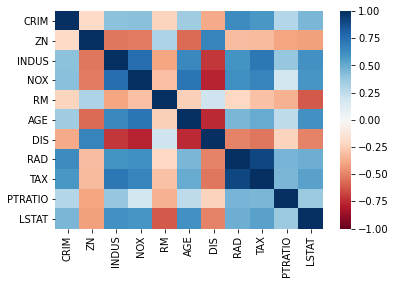

In [10]:
corr = predictors_df.corr()
# corr.style.background_gradient()
_ = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, vmin=-1, vmax=1, 
            cmap="RdBu")

In [11]:
# correlation table
corr

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
CRIM,1.000000,-0.200469,0.406583,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,0.455621
ZN,-0.200469,1.000000,-0.533828,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,-0.412995
INDUS,0.406583,-0.533828,1.000000,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,0.603800
NOX,0.420972,-0.516604,0.763651,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,0.590879
RM,-0.219247,0.311991,-0.391676,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,-0.613808
AGE,0.352734,-0.569537,0.644779,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,0.602339
DIS,-0.379670,0.664408,-0.708027,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,-0.496996
RAD,0.625505,-0.311948,0.595129,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,0.488676
TAX,0.582764,-0.314563,0.720760,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,0.543993
PTRATIO,0.289946,-0.391679,0.383248,0.188933,-0.355501,0.261515,-0.232471,0.464741,0.460853,1.000000,0.374044


If the correlation between variables if greater than 0.7 we can say that the two variables are highly correlated. From the above table, the pairs of highly correlated variables are:

1) NOX and INDUS: Correlation coefficient = 0.763651

2) TAX and INDUS: Correlation coefficient = 0.72076

3) AGE and NOX: Correlation coefficient = 0.73147

4) DIS and NOX: Correlation coefficient = -0.76923

5) DIS and AGE: Correlation coefficient = -0.747881

6) TAX and RAD: Correlation coefficient = 0.910228

According to the correlation table, we might be able to remove some variables that do not add much information to others that we keep. We might remove INDUS, AGE and TAX.

__6.1.d.iii.__ Use stepwise regression with the three options (backward, forward, both) to reduce the remaining predictors as follows: Run stepwise on the training set. Choose the top model from each stepwise run. Then use each of these models separately to predict the validation set. Compare RMSE, MAPE, and mean error, as well as lift charts. Finally, describe the best model.

__Answer:__

In [12]:
# partition the data into training (60%) and validation (40%) sets
predictors = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT']
outcome = 'MEDV'

# partition the data
X = pd.get_dummies(housing_df[predictors], drop_first=True)
y = housing_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

print('Training set:', train_X.shape, 'Validation set:', valid_X.shape)

Training set: (303, 12) Validation set: (203, 12)


NOTE: There is currently no support in scikit-learn or statsmodels for stepwise regression. It is however straightforward to 
implement such an approach in a few lines of code using the `dmba` implementation.

In [13]:
# backward elimination

def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = backward_elimination(train_X.columns, train_model, score_model, verbose=True)

print("Best Subset:", best_variables)


Variables: CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, LSTAT
Start: score=1807.23
Step: score=1805.30, remove AGE
Step: score=1803.57, remove INDUS
Step: score=1803.57, remove None
Best Subset: ['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT']


In [14]:
# forward selection
# The initial model is the constant model - this requires special handling in train_model and score_model

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)

print("Best Subset:", best_variables)

Variables: CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, LSTAT
Start: score=2191.75, constant
Step: score=1934.91, add LSTAT
Step: score=1874.18, add RM
Step: score=1842.54, add PTRATIO
Step: score=1837.69, add CHAS


Step: score=1835.00, add NOX
Step: score=1817.90, add DIS
Step: score=1811.82, add ZN
Step: score=1810.16, add CRIM
Step: score=1808.01, add RAD
Step: score=1803.57, add TAX
Step: score=1803.57, add None
Best Subset: ['LSTAT', 'RM', 'PTRATIO', 'CHAS', 'NOX', 'DIS', 'ZN', 'CRIM', 'RAD', 'TAX']


In [15]:
# stepwise (both) method
best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)
print("Best Subset:", best_variables)

Variables: CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, LSTAT
Start: score=2191.75, constant
Step: score=1934.91, add LSTAT
Step: score=1874.18, add RM
Step: score=1842.54, add PTRATIO
Step: score=1837.69, add CHAS


Step: score=1835.00, add NOX


Step: score=1817.90, add DIS
Step: score=1811.82, add ZN
Step: score=1810.16, add CRIM
Step: score=1808.01, add RAD
Step: score=1803.57, add TAX


Step: score=1803.57, unchanged None
Best Subset: ['LSTAT', 'RM', 'PTRATIO', 'CHAS', 'NOX', 'DIS', 'ZN', 'CRIM', 'RAD', 'TAX']


Above we see that all three subset selection methods gave the same best subset/model:
Each model is designed using the following 10 variables: LSTAT, RM, PTRATIO, CHAS, NOX, DIS, ZN, CRIM, RAD, TAX. 

In [16]:
# fit the model with best subset variables
outcome = 'MEDV'
predictors = ['LSTAT', 'RM', 'PTRATIO', 'CHAS', 'NOX', 'DIS', 'ZN', 'CRIM', 'RAD', 'TAX']

X = train_X[predictors]
y = train_y

# fit the regression model y on X
house_lm = LinearRegression()
house_lm.fit(X,y)

# regression model, print coefficients
print('intercept', house_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': house_lm.coef_}))

# print performance measures (training set)
print("\nModel performance on training data:")
regressionSummary(train_y, house_lm.predict(train_X[predictors]))

# predict prices in validation set, print first few predicted/actual values and residuals
house_lm_pred = house_lm.predict(valid_X[predictors])
result = pd.DataFrame({'Predicted': house_lm_pred, 'Actual': valid_y, 'Residual': valid_y - house_lm_pred})

# print performance measures (validation set)
print("\nModel performance on validation data:")
regressionSummary(valid_y, house_lm_pred)

intercept 38.95615649828216
  Predictor  coefficient
0     LSTAT    -0.514444
1        RM     3.480964
2   PTRATIO    -0.804964
3      CHAS     2.359986
4       NOX   -17.866926
5       DIS    -1.438596
6        ZN     0.066221
7      CRIM    -0.114137
8       RAD     0.262455
9       TAX    -0.011166

Model performance on training data:

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 4.5615
            Mean Absolute Error (MAE) : 3.1662
          Mean Percentage Error (MPE) : -3.4181
Mean Absolute Percentage Error (MAPE) : 16.4898

Model performance on validation data:

Regression statistics

                      Mean Error (ME) : -0.0393
       Root Mean Squared Error (RMSE) : 5.0771
            Mean Absolute Error (MAE) : 3.5746
          Mean Percentage Error (MPE) : -5.1561
Mean Absolute Percentage Error (MAPE) : 16.9733


# Problem 6.2 Predicting Software Reselling Profits.

Tayko Software is a software catalog firm that sells games and educational software. It started out as a software manufacturer and then added third-party titles to its oﬀerings. It recently revised its collection of items in a new catalog, which it mailed out to its customers. This mailing yielded 2000 purchases. Based on these data, Tayko wants to devise a model for predicting the spending amount that a purchasing customer will yield. The file _Tayko.csv_ contains information on 2000 purchases. Table 6.12 describes the variables to be used in the problem (the Excel file contains additional variables).

![TABLE 6.12](img/TABLE_6.12.PNG) 


In [17]:
# load the data
tayko_df = pd.read_csv(DATA / 'Tayko.csv')
# check data dimension
tayko_df.shape

(2000, 25)

In [18]:
# check variable names
list(tayko_df.columns)

['sequence_number',
 'US',
 'source_a',
 'source_c',
 'source_b',
 'source_d',
 'source_e',
 'source_m',
 'source_o',
 'source_h',
 'source_r',
 'source_s',
 'source_t',
 'source_u',
 'source_p',
 'source_x',
 'source_w',
 'Freq',
 'last_update_days_ago',
 '1st_update_days_ago',
 'Web order',
 'Gender=male',
 'Address_is_res',
 'Purchase',
 'Spending']

In [19]:
# modify column names
tayko_df.columns = [c.replace(' ', '_').replace('=', '_') for c in tayko_df.columns]

In [20]:
# review first few record
tayko_df.head()

,sequence_number,US,source_a,source_c,source_b,source_d,source_e,source_m,source_o,source_h,...,source_x,source_w,Freq,last_update_days_ago,1st_update_days_ago,Web_order,Gender_male,Address_is_res,Purchase,Spending
0,1,1,0,0,1,0,0,0,0,0,...,0,0,2,3662,3662,1,0,1,1,128
1,2,1,0,0,0,0,1,0,0,0,...,0,0,0,2900,2900,1,1,0,0,0
2,3,1,0,0,0,0,0,0,0,0,...,0,0,2,3883,3914,0,0,0,1,127
3,4,1,0,1,0,0,0,0,0,0,...,0,0,1,829,829,0,1,0,0,0
4,5,1,0,1,0,0,0,0,0,0,...,0,0,1,869,869,0,0,0,0,0


In [21]:
# check data types of variables in the data
tayko_df.dtypes

sequence_number         int64
US                      int64
source_a                int64
source_c                int64
source_b                int64
source_d                int64
source_e                int64
source_m                int64
source_o                int64
source_h                int64
source_r                int64
source_s                int64
source_t                int64
source_u                int64
source_p                int64
source_x                int64
source_w                int64
Freq                    int64
last_update_days_ago    int64
1st_update_days_ago     int64
Web_order               int64
Gender_male             int64
Address_is_res          int64
Purchase                int64
Spending                int64
dtype: object

__6.2.a__ Explore the spending amount by creating a pivot table for the categorical variables and computing the average and standard deviation of spending in each category. 

__Answer:__ 

In [22]:
# select only required variables
selected_var = ['US', 'Freq', 'last_update_days_ago', 'Web_order', 'Gender_male', 'Address_is_res', 'Spending']
tayko_df = tayko_df[selected_var]
list(selected_var)

['US',
 'Freq',
 'last_update_days_ago',
 'Web_order',
 'Gender_male',
 'Address_is_res',
 'Spending']

In [23]:
# pivot table: spending by gender
pd.pivot_table(tayko_df, index= 'Gender_male', values= "Spending",
               aggfunc= [np.mean, np.std])

,mean,std
,Spending,Spending
Gender_male,,
0,107.339642,190.83233
1,98.350810,183.02006


In [24]:
# pivot table: spending by web order
pd.pivot_table(tayko_df, index= 'Web_order', values= "Spending",
               aggfunc= [np.mean, np.std])

,mean,std
,Spending,Spending
Web_order,,
0,82.902439,173.417088
1,129.199531,200.463840


In [25]:
# pivot table: spending by adress
pd.pivot_table(tayko_df, index= 'Address_is_res', values= "Spending",
               aggfunc= [np.mean, np.std])

,mean,std
,Spending,Spending
Address_is_res,,
0,105.306162,199.521159
1,93.174208,132.204281


In [26]:
# pivot table: spending by whether it is US address
pd.pivot_table(tayko_df, index= 'US', values= "Spending",
               aggfunc= [np.mean, np.std])

,mean,std
,Spending,Spending
US,,
0,101.216524,174.844401
1,102.924803,189.275664


__6.2.b.__ Explore the relationship between spending and each of the two continuous predictors by creating two scatterplots (Spending vs. Freq, and Spending vs. last_update_days_ago. Does there seem to be a linear relationship? 

__Answer:__ 

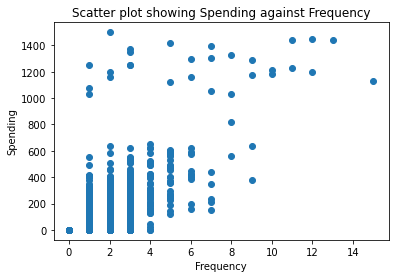

In [27]:
# plot of spending against frequency
plt.scatter(tayko_df.Freq, tayko_df.Spending)
plt.title('Scatter plot showing Spending against Frequency')
plt.ylabel('Spending')
plt.xlabel('Frequency')
plt.show()

The overall relationship between Spending and Freq does not appear to be linear. However, there do appear to be two groups of points (Spending < 800 and Spending > 800), and within each group there appears to be a linear relationship between SPENDING and FREQ.

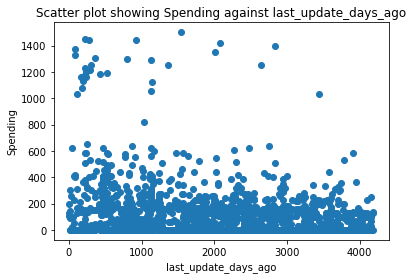

In [28]:
# plot Spending against last_update_days_ago
plt.scatter(tayko_df.last_update_days_ago, tayko_df.Spending)
plt.title('Scatter plot showing Spending against last_update_days_ago')
plt.ylabel('Spending')
plt.xlabel('last_update_days_ago')
plt.show()

There appears to be no relationship between Spending and Last_Update but two grous of points similar to what we seen in case of Spending and Frequency above.

__6.2.c.__ To fit a predictive model for spending:

__6.2.c.i.__ Partition the 2000 records into training and validation sets.

__Answer:__ 

In [29]:
# predictors and outcome
predictors = ['US', 'Freq', 'last_update_days_ago', 'Web_order', 'Gender_male', 'Address_is_res']
outcome = 'Spending'
X = tayko_df[predictors]
y = tayko_df[outcome]

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.4, random_state = 1)
print('Training set:', train_X.shape, 'Validation set:', valid_X.shape)

Training set: (1200, 6) Validation set: (800, 6)


__6.2.c.ii.__ Run a multiple linear regression model for Spending vs. all six predictors. Give the estimated predictive equation.

__Answer:__ 

In [30]:
# fit the regression model
tayko_lm = LinearRegression()
tayko_lm.fit(train_X, train_y)

# print coefficients
print('Intercept', tayko_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': tayko_lm.coef_}))

Intercept 10.17629741458822
              Predictor  coefficient
0                    US    -4.620293
1                  Freq    91.274450
2  last_update_days_ago    -0.010374
3             Web_order    18.628731
4           Gender_male    -9.111366
5        Address_is_res   -75.815354


The Regression equation is:

Spending = 10.176297 + (-4.620293 * US) + (91.274450 * Freq) + (-0.010347 * last_update_days_ago) + 
(18.628731 * Web_order) + (-9.111366 * Gender_male) + (-75.815354 * Address_is_res)

__6.2.c.iii.__ Based on this model, what type of purchaser is most likely to spend a large amount of money?

 __Answer:__

A purchaser with frequent catalog transactions in the last year and who has purchased by Web order at least once. This is based on the signs of the coefficients and on their statistical significance (low p-values).

In [31]:
# here we use sm.ols method in statsmodels which provides more information (P-values etc.) on model fit 
# run a linear regression of Spending on the predictors in the training set
train_df = train_X.join(train_y)

predictors = train_X.columns
formula = 'Spending ~ ' + ' + '.join(predictors)

tayko_lm = sm.ols(formula=formula, data=train_df).fit()
print(tayko_lm.summary())

                            OLS Regression Results                            
Dep. Variable:               Spending   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     219.3
Date:                Sun, 08 Mar 2020   Prob (F-statistic):          1.26e-188
Time:                        20:19:30   Log-Likelihood:                -7506.3
No. Observations:                1200   AIC:                         1.503e+04
Df Residuals:                    1193   BIC:                         1.506e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               10.1763 

__6.2.c.iv.__ If we used backward elimination to reduce the number of predictors, which predictor would be dropped first from the model?

__Answer:__ 

Based on the above model, US has the highest p-value. Therefore backward elimination would drop "US" first from the model.

__6.2.c.v.__ Show how the prediction and the prediction error are computed for the first purchase in the validation set.

__Answer:__ 

In [32]:
valid_df = valid_X.join(valid_y)
first_obs_valid = valid_df.head(1)
print(first_obs_valid)

     US  Freq  last_update_days_ago  Web_order  Gender_male  Address_is_res  \
674   1     2                  1346          0            1               1   

     Spending  
674         0  


Here, we need to calculate the predicted value for the first observation of validation set. The values corresponding to the first observation of validation set are:

In [33]:
US = 1; Freq = 1; last_update_days_ago = 869; Web_order = 0; Gender_male = 0; Address_is_res = 0

In [34]:
Spending = 10.176297+(-4.620293*US)+(91.274450*Freq)+(-0.010347*last_update_days_ago)+(18.628731*Web_order)+ (-9.111366*Gender_male)+(-75.815354*Address_is_res)
print(Spending)

87.838911


In [35]:
# prediction error. subtract 0 from predicted value as response (Spending) value for the first record in the validation data
# is zero.
print('Prediction Error = ',Spending - 0)

Prediction Error =  87.838911


__6.2.c.vi.__ Evaluate the predictive accuracy of the model by examining its performance on the validation set.

__Answer:__

The Average error is 7 dollars, with an RMSE of 137.7 dollars. This level of error is practically small given that values of spending in the data are in the range 0 - 1500 dollars. We also see that the validation set performance is approximately similar to the training set performance, indicating no overfitting.

In [36]:
# print performance measures (training set)
print("\nModel performance on training data:")
regressionSummary(train_y, tayko_lm.predict(train_X[predictors]))

# predict prices in validation set, print first few predicted/actual values and residuals
# we go back to the model we fitted using sklearn
tayko_lm_pred = tayko_lm.predict(valid_X[predictors])
result = pd.DataFrame({'Predicted': tayko_lm_pred, 'Actual': valid_y, 'Residual': valid_y - tayko_lm_pred})
print("First few  predicted/actual values and residuals:\n")
print(result.head(5))

# print performance measures (validation set)
print("\nModel performance on validation data:")
regressionSummary(valid_y, tayko_lm_pred)


Model performance on training data:

Regression statistics

               Mean Error (ME) : 0.0000
Root Mean Squared Error (RMSE) : 125.9999
     Mean Absolute Error (MAE) : 79.4772
First few  predicted/actual values and residuals:

       Predicted  Actual    Residual
674    89.214915       0  -89.214915
1699  202.231362     184  -18.231362
1282   49.159303       0  -49.159303
1315  824.841659    1289  464.158341
1210    0.121196       0   -0.121196

Model performance on validation data:

Regression statistics

               Mean Error (ME) : 7.1933
Root Mean Squared Error (RMSE) : 136.7397
     Mean Absolute Error (MAE) : 83.6010


__6.2.c.vii.__ Create a histogram of the model residuals. Do they appear to follow a normal distribution? How does this aﬀect the predictive performance of the model?

__Answer:__ 

The histogram of residuals doesn't appear to be normal. However, this is not a great handicap -- the assumption of normally distributed residuals is required for classically-derived confidence intervals, but not so much in data mining, where redictive accuracy is assessed in another way (evaluating performance on the validation data).

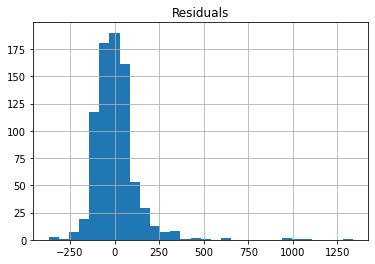

In [37]:
# compute and plot the residuals for validation data
all_residuals = valid_y - tayko_lm_pred
pd.DataFrame({'Residuals': all_residuals}).hist(bins=30)
plt.show()

# Problem 6.3 Predicting Airfare on New Routes.

The following problem takes place in the United States in the late 1990s, when many major US cities were facing issues with airport congestion, partly as a result of the 1978 deregulation of airlines. Both fares and routes were freed from regulation, and low-fare carriers such as Southwest (SW) began competing on existing routes and starting nonstop service on routes that previously lacked it. Building completely new airports is generally not feasible, but sometimes decommissioned military bases or smaller municipal airports can be reconfgured as regional or larger commercial airports. There are numerous players and interests involved in the issue (airlines, city, state and federal authorities, civic groups, the military, airport operators), and an aviation consulting firm is seeking advisory contracts with these players. The frm needs predictive models to support its consulting service. One thing the frm might want to be able to predict is fares, in the event a new airport is brought into service. The frm starts with the fle Airfares.csv, which contains real data that were collected between Q3-1996 and Q2-1997. The variables in these data are listed in Table 6.13, and are believed to be important in predicting FARE. Some airport-to-airport data are available, but most data are at the city-to-city level. One question that will be of interest in the analysis is the eﬀect that the presence or absence of Southwest has on FARE.

![TABLE6.13](img\TABLE_6.13.PNG)


In [38]:
# load the data and review
airfares_df = pd.read_csv(DATA / 'Airfares.csv')
# check data dimension
print('\ndimension\n',airfares_df.shape)
# view few records
print('\nfirst five record\n')
print(airfares_df.head())
# variable types
print('\nData Type')
airfares_df.dtypes


dimension
 (638, 18)

first five record

  S_CODE                  S_CITY E_CODE                  E_CITY  COUPON  NEW  \
0      *  Dallas/Fort Worth   TX      *  Amarillo            TX    1.00    3   
1      *  Atlanta             GA      *  Baltimore/Wash Intl MD    1.06    3   
2      *  Boston              MA      *  Baltimore/Wash Intl MD    1.06    3   
3    ORD  Chicago             IL      *  Baltimore/Wash Intl MD    1.06    3   
4    MDW  Chicago             IL      *  Baltimore/Wash Intl MD    1.06    3   

  VACATION   SW       HI  S_INCOME  E_INCOME    S_POP    E_POP        SLOT  \
0       No  Yes  5291.99   28637.0   21112.0  3036732   205711        Free   
1       No   No  5419.16   26993.0   29838.0  3532657  7145897        Free   
2       No   No  9185.28   30124.0   29838.0  5787293  7145897        Free   
3       No  Yes  2657.35   29260.0   29838.0  7830332  7145897  Controlled   
4       No  Yes  2657.35   29260.0   29838.0  7830332  7145897        Free   

   GATE 

S_CODE       object
S_CITY       object
E_CODE       object
E_CITY       object
COUPON      float64
NEW           int64
VACATION     object
SW           object
HI          float64
S_INCOME    float64
E_INCOME    float64
S_POP         int64
E_POP         int64
SLOT         object
GATE         object
DISTANCE      int64
PAX           int64
FARE        float64
dtype: object

In [39]:
# preprocess
# remove first four variables 'S_CODE', 'S_CITY', 'E_CODE', 'E_CITY'
selected_var = ['COUPON', 'NEW', 'VACATION', 'SW', 'HI', 'S_INCOME', 'E_INCOME', 'S_POP', 'E_POP', 'SLOT', 'GATE',
                'DISTANCE', 'PAX', 'FARE']
airfares_df = airfares_df[selected_var]
airfares_df.dtypes

COUPON      float64
NEW           int64
VACATION     object
SW           object
HI          float64
S_INCOME    float64
E_INCOME    float64
S_POP         int64
E_POP         int64
SLOT         object
GATE         object
DISTANCE      int64
PAX           int64
FARE        float64
dtype: object

__6.3.a.__ Explore the numerical predictors and response (FARE) by creating a correlation table and examining some scatterplots between FARE and those predictors. What seems to be the best single predictor of FARE?

__Answer:__

In [40]:
# create a new dataframe with numerical predictors
predictors_df = airfares_df

columns = list(airfares_df.columns)
columns.remove('VACATION')
columns.remove('SW')
columns.remove('SLOT')
columns.remove('GATE')
predictors_df = predictors_df[columns]
predictors_df.columns

Index(['COUPON', 'NEW', 'HI', 'S_INCOME', 'E_INCOME', 'S_POP', 'E_POP',
       'DISTANCE', 'PAX', 'FARE'],
      dtype='object')

In [41]:
#correlation table
predictors_df.corr()
#corr.style.background_gradient()

,COUPON,NEW,HI,S_INCOME,E_INCOME,S_POP,E_POP,DISTANCE,PAX,FARE
COUPON,1.000000,0.020223,-0.347252,-0.088403,0.046889,-0.107763,0.094970,0.746805,-0.336974,0.496537
NEW,0.020223,1.000000,0.054147,0.026597,0.113377,-0.016672,0.058568,0.080965,0.010495,0.091730
HI,-0.347252,0.054147,1.000000,-0.027382,0.082393,-0.172495,-0.062456,-0.312375,-0.168961,0.025195
S_INCOME,-0.088403,0.026597,-0.027382,1.000000,-0.138864,0.517187,-0.272280,0.028153,0.138197,0.209135
E_INCOME,0.046889,0.113377,0.082393,-0.138864,1.000000,-0.144059,0.458418,0.176531,0.259961,0.326092
S_POP,-0.107763,-0.016672,-0.172495,0.517187,-0.144059,1.000000,-0.280143,0.018437,0.284611,0.145097
E_POP,0.094970,0.058568,-0.062456,-0.272280,0.458418,-0.280143,1.000000,0.115640,0.314698,0.285043
DISTANCE,0.746805,0.080965,-0.312375,0.028153,0.176531,0.018437,0.115640,1.000000,-0.102482,0.670016
PAX,-0.336974,0.010495,-0.168961,0.138197,0.259961,0.284611,0.314698,-0.102482,1.000000,-0.090705
FARE,0.496537,0.091730,0.025195,0.209135,0.326092,0.145097,0.285043,0.670016,-0.090705,1.000000


DISTANCE is the best single predictor of FARE with correlation coefficient of 0.67.

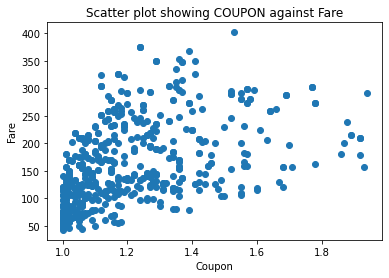

In [42]:
# Plot of coupon against fare
plt.scatter(airfares_df.COUPON, airfares_df.FARE)
plt.title('Scatter plot showing COUPON against Fare')
plt.xlabel('Coupon')
plt.ylabel('Fare')
plt.show()

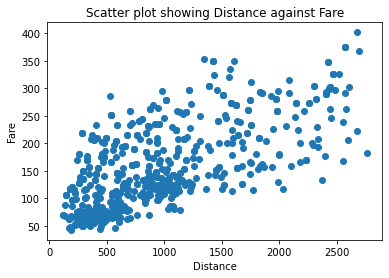

In [43]:
# Plot of distance against fare
plt.scatter(airfares_df.DISTANCE, airfares_df.FARE)
plt.title('Scatter plot showing Distance against Fare')
plt.xlabel('Distance')
plt.ylabel('Fare')
plt.show()

__6.3.b.__ Explore the categorical predictors (excluding the first four) by computing the percentage of ﬂights in each category. Create a pivot table with the average fare in each category. Which categorical predictor seems best for predicting FARE?

__Answer:__ 

In [44]:
pivot1 = pd.pivot_table(airfares_df, index= 'VACATION', values= "FARE",
               aggfunc= [np.mean])
print(pivot1)

                mean
                FARE
VACATION            
No        173.552500
Yes       125.980882


In [45]:
pd.pivot_table(airfares_df, index= 'SW', values= "FARE",
               aggfunc= [np.mean])

,mean
,FARE
SW,
No,188.182793
Yes,98.382268


In [46]:
pd.pivot_table(airfares_df, index= 'SLOT', values= "FARE",
               aggfunc= [np.mean])

,mean
,FARE
SLOT,
Controlled,186.059396
Free,150.825680


In [47]:
pd.pivot_table(airfares_df, index= 'GATE', values= "FARE",
               aggfunc= [np.mean])

,mean
,FARE
GATE,
Constrained,193.129032
Free,153.095953


SW is the single best categorical predictor of FARE.

__6.3.c.__ Find a model for predicting the average fare on a new route:

__6.3.c.i.__ Convert categorical variables (e.g., SW) into dummy variables. Then, partition the data into training and validation sets. The model will be fit to the training data and evaluated on the validation set.

__Answer:__ 

The columns VACATION, SW, SLOT, and GATE are not numeric. Convert them to numeric.

In [48]:
airfares_df['VACATION'] = [1 if v == 'Yes' else 0 for v in airfares_df['VACATION']]
airfares_df['SW'] = [1 if v == 'Yes' else 0 for v in airfares_df['SW']]
airfares_df['SLOT'] = [1 if v == 'Controlled' else 0 for v in airfares_df['SLOT']]
airfares_df['GATE'] = [1 if v == 'Constrained' else 0 for v in airfares_df['GATE']]

In [49]:
#partition the data into training (60%) and validation (40%) sets
predictors = ['COUPON', 'NEW', 'VACATION', 'SW', 'HI', 'S_INCOME', 'E_INCOME', 'S_POP', 'E_POP', 'SLOT', 'GATE', 'DISTANCE',
              'PAX']
outcome = 'FARE'

# partition the data
X = pd.get_dummies(airfares_df[predictors], drop_first=True)
y = airfares_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

print('Training set:', train_X.shape, 'Validation set:', valid_X.shape)

Training set: (382, 13) Validation set: (256, 13)


__6.3.c.ii.__ Use stepwise regression to reduce the number of predictors. You can ignore the frst four predictors (S_CODE, S_CITY, E_CODE, E_CITY). Report the estimated model selected.

__Answer:__ 

In [50]:
# stepwise regression
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)
print("Best Subset:", best_variables)

Variables: COUPON, NEW, VACATION, SW, HI, S_INCOME, E_INCOME, S_POP, E_POP, SLOT, GATE, DISTANCE, PAX
Start: score=4379.42, constant
Step: score=4149.88, add DISTANCE
Step: score=4025.89, add SW
Step: score=3913.59, add VACATION
Step: score=3890.27, add HI


Step: score=3873.33, add GATE
Step: score=3852.81, add SLOT


Step: score=3850.30, add PAX
Step: score=3844.58, add E_POP
Step: score=3826.43, add S_POP


Step: score=3821.88, add E_INCOME


Step: score=3821.88, unchanged None
Best Subset: ['DISTANCE', 'SW', 'VACATION', 'HI', 'GATE', 'SLOT', 'PAX', 'E_POP', 'S_POP', 'E_INCOME']


According to the output the model with 10 predictors (11 coefficients) is the best one.

__6.3.c.iii.__ Repeat (ii) using exhaustive search instead of stepwise regression. Compare the resulting best model to the one you obtained in (ii) in terms of the predictors that are in the model.

__Answer:__ 

In [51]:
# exhaustive search
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))
pd.reset_option('display.width')

     n     r2adj          AIC  COUPON  DISTANCE  E_INCOME  E_POP   GATE     HI    NEW    PAX  \
0    1  0.453107  4149.881509   False      True     False  False  False  False  False  False   
1    2  0.605715  4025.892420   False      True     False  False  False  False  False  False   
2    3  0.706909  3913.585125   False      True     False  False  False  False  False  False   
3    4  0.724977  3890.268211   False      True     False  False  False   True  False  False   
4    5  0.737584  3873.328296   False      True     False  False   True   True  False  False   
5    6  0.751947  3852.808698   False      True     False  False   True   True  False  False   
6    7  0.758747  3843.170960   False      True     False   True  False   True  False   True   
7    8  0.765105  3833.945866   False      True     False   True   True   True  False   True   
8    9  0.770266  3826.433471   False      True     False   True   True   True  False   True   
9   10  0.773567  3821.876901   False   

Stepwise selection produced best model with these 10 variables (11 coefficients): 'DISTANCE', 'SW', 'VACATION', 'HI', 'GATE', 'SLOT', 'PAX', 'E_POP', 'S_POP', 'E_INCOME'. It excluded variables named COUPON, NEW and S_INCOME.

Exhaustive search also produced a model with 10 predictors (11 coefficients) which is the best one (according to adjusted R-squared and AIC values). It excluded the same variables named COUPON, NEW and S_INCOME.

__6.3.c.iv.__ Compare the predictive accuracy of both models (ii) and (iii) using measures such as RMSE and average error and lift charts.

__Answer:__

Since models are same they will have the same predictive accuracy.

In [52]:
# predictors and outcome
predictors = ['DISTANCE', 'SW', 'VACATION', 'HI', 'GATE', 'SLOT', 'PAX', 'E_POP', 'S_POP', 'E_INCOME']
outcome = 'FARE'
X = train_X[predictors]
y = train_y

# fit the regression model y on x
airfares_lm = LinearRegression()
airfares_lm.fit(X,y)

# print coefficients
print('intercept ', airfares_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': airfares_lm.coef_}))

# print performance measures (training set)
print("\nModel performance on training data:")
regressionSummary(train_y, airfares_lm.predict(train_X[predictors]))

# predict prices in validation set, print first few predicted/actual values and residuals
airfares_lm_pred = airfares_lm.predict(valid_X[predictors])

# print performance measures (validation set)
print("\nModel performance on validation data:")
regressionSummary(valid_y, airfares_lm_pred)


intercept  17.56489387958925
  Predictor  coefficient
0  DISTANCE     0.075558
1        SW   -43.031272
2  VACATION   -35.865596
3        HI     0.007188
4      GATE    21.410803
5      SLOT    13.915304
6       PAX    -0.000829
7     E_POP     0.000004
8     S_POP     0.000004
9  E_INCOME     0.001148

Model performance on training data:

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 34.8867
            Mean Absolute Error (MAE) : 27.1374
          Mean Percentage Error (MPE) : -4.5313
Mean Absolute Percentage Error (MAPE) : 20.1672

Model performance on validation data:

Regression statistics

                      Mean Error (ME) : -1.8591
       Root Mean Squared Error (RMSE) : 36.1129
            Mean Absolute Error (MAE) : 28.5252
          Mean Percentage Error (MPE) : -6.7084
Mean Absolute Percentage Error (MAPE) : 21.7198


__6.3.c.v.__ Using model (iii), predict the average fare on a route with the following characteristics: COUPON = 1.202, NEW = 3, VACATION = No, SW = No, HI = 4442.141, S_INCOME = 28,760, E_INCOME = 27,664, S_POP = 4,557,004, E_POP = 3,195,503, SLOT = Free, GATE = Free, PAX = 12,782, DISTANCE = 1976 miles.

__Answer:__ 

In [53]:
# Fare when SW does not cover this route
# enter new data in data frame format
new_data = pd.DataFrame([
    {'VACATION': 0, 'SW': 0, 'HI': 4442.141, 'E_INCOME': 27664, 'S_POP': 4557004, 'E_POP': 3195503, 'SLOT': 1, 'GATE': 1,
     'PAX': 12782, 'DISTANCE': 1976}])
    
print(new_data)

   VACATION  SW        HI  E_INCOME    S_POP    E_POP  SLOT  GATE    PAX  \
0         0   0  4442.141     27664  4557004  3195503     1     1  12782   

   DISTANCE  
0      1976  


In [54]:
# predict Fare when SW does not cover this route
pred = airfares_lm.predict(new_data[predictors])
print(pred)

[287.04763737]


__6.3.c.vi.__ Predict the reduction in average fare on the route in (v) if Southwest decides to cover this route [using model (iii)].

__Answer:__ 

In [55]:
# predict Fare when SW decides to cover this route
new_data = pd.DataFrame([
    {'VACATION': 0, 'SW': 1, 'HI': 4442.141, 'S_INCOME': 28760, 'E_INCOME': 27664, 'S_POP': 4557004, 'E_POP': 3195503, 'SLOT': 1, 'GATE': 1,
     'PAX': 12782, 'DISTANCE': 1976}])
pred1 = airfares_lm.predict(new_data[predictors])
print(pred1)

[244.01636531]


In [56]:
# reduction in average fare after southwest decided to cover this route
reduction = pred - pred1
print(reduction)

[43.03127206]


So the reduction in average fare after southwest decided to cover this route is $43.

__6.3.c.vii.__ In reality, which of the factors will not be available for predicting the average fare from a new airport (i.e., before ﬂights start operating on those routes)? Which ones can be estimated? How?

__Answer:__

Several of the variables would not be available until after flights start operating on the route.
         
 COUPON    - Not Available   
 NEW       - Not Available   
 VACATION  - Available      
 SW        - Not Available  
 HI        - Not Available   
 S_INCOME  - Available    
 E_INCOME  - Available    
 S_POP     - Available    
 E_POP     - Available    
 SLOT      - Available    
 GATE      - Available    
 DISTANCE  - Available    
 PAX       - Not Available  

__6.3.c.viii.__ Select a model that includes only factors that are available before ﬂights begin to operate on the new route. Use an exhaustive search to fnd such a model.

__Answer:__

In [57]:
# partition the data into training (60%) and validation (40%) sets
predictors = ['VACATION', 'S_INCOME', 'E_INCOME', 'S_POP', 'E_POP', 'SLOT', 'GATE', 'DISTANCE']
outcome = 'FARE'

# partition the data
X = pd.get_dummies(airfares_df[predictors], drop_first=True)
y = airfares_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

print('Training set:', train_X.shape, 'Validation set:', valid_X.shape)

Training set: (382, 8) Validation set: (256, 8)


In [58]:
# exhaustive search
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))
pd.reset_option('display.width')

   n     r2adj          AIC  DISTANCE  E_INCOME  E_POP   GATE   SLOT  S_INCOME  S_POP  VACATION
0  1  0.453107  4149.881509      True     False  False  False  False     False  False     False
1  2  0.562472  4065.645719      True     False  False  False  False     False  False      True
2  3  0.607897  4024.763754      True     False  False   True  False     False  False      True
3  4  0.639707  3993.431429      True     False  False   True   True     False  False      True
4  5  0.655706  3977.066487      True      True  False   True   True     False  False      True
5  6  0.660329  3972.885153      True      True  False   True   True      True  False      True
6  7  0.664409  3969.248469      True      True   True   True   True      True  False      True
7  8  0.663807  3970.910599      True      True   True   True   True      True   True      True


Model with 7 predictors (8 coefficients) is the best one among other models in this case. That excludes the predictor S_POP.

__6.3.c.ix.__ Use the model in (viii) to predict the average fare on a route with characteristics COUPON = 1.202, NEW = 3, VACATION = No, SW = No, HI = 4442.141, S_INCOME = 28,760, E_INCOME = 27,664, S_ POP = 4,557,004, E_POP = 3,195,503, SLOT = Free, GATE = Free, PAX = 12782, DISTANCE = 1976 miles.

__Answer:__ 

In [59]:
# predictors and outcome
predictors = ['DISTANCE', 'VACATION', 'GATE', 'SLOT', 'E_POP', 'E_INCOME', 'S_INCOME']
outcome = 'FARE'
X = train_X[predictors]
y = train_y

#fit the regression model y on x
airfares_lm = LinearRegression()
airfares_lm.fit(X,y)

# print coefficients
print('intercept ', airfares_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': airfares_lm.coef_}))

# print performance measures (training set)
print("\nModel performance on training data:")
regressionSummary(train_y, airfares_lm.predict(train_X[predictors]))

# predict prices in validation set, print first few predicted/actual values and residuals
airfares_lm_pred = airfares_lm.predict(valid_X[predictors])

# print performance measures (validation set)
print("\nModel performance on validation data:")
regressionSummary(valid_y, airfares_lm_pred)


intercept  -40.8073738366258
  Predictor  coefficient
0  DISTANCE     0.077434
1  VACATION   -41.230763
2      GATE    38.056133
3      SLOT    18.903701
4     E_POP     0.000002
5  E_INCOME     0.001974
6  S_INCOME     0.002240

Model performance on training data:

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 42.6426
            Mean Absolute Error (MAE) : 33.6897
          Mean Percentage Error (MPE) : -8.2491
Mean Absolute Percentage Error (MAPE) : 25.3452

Model performance on validation data:

Regression statistics

                      Mean Error (ME) : 0.3728
       Root Mean Squared Error (RMSE) : 43.8816
            Mean Absolute Error (MAE) : 35.2079
          Mean Percentage Error (MPE) : -9.9589
Mean Absolute Percentage Error (MAPE) : 26.4530


In [60]:
# predict Fare for new data
print(airfares_lm.predict(new_data[predictors]))

[295.58795228]


So the average fare on this route is $295.59. 

__6.3.c.x.__ Compare the predictive accuracy of this model with model (iii). Is this model good enough, or is it worthwhile reevaluating the model once ﬂights begin on the new route?

__Answer:__ 

RMS error is higher in model (viii). We need to reevaluate the model once flights commence on the new routes.

__6.3.d.__ In competitive industries, a new entrant with a novel business plan can have a disruptive eﬀect on existing firms. If a new entrant’s business model is sustainable, other players are forced to respond by changing their business practices. If the goal of the analysis was to evaluate the eﬀect of Southwest Airlines’ presence on the airline industry rather than predicting fares on new routes, how would the analysis be diﬀerent? Describe technical and conceptual aspects.

__Answer:__

The analysis might look also at fares overall, instead of just on the new routes, PAX overall instead of just on the new routes; both are available. 

Also industry profit, which is not among the variables.

Other differences would be:

(1)  In an explanatory model, we would include predictors even if they are only known retrospectively (such predictors cannot be used in a predictive model). 

(2) Although predictive accuracy is important for validating the usefulness of an explanatory model, the focus in explanatory modeling is on the correct specification of the model in the sense that the "right model" was fit to the data.

Since explanatory models can be conducted with relatively small data sets, it is common not to partition the data, but rather use the same set of data to fit the model and to assess goodness-of-fit (with measures like R-squared, and residual analysis).

(3) The emphasis in an explanatory model would be on the interpretation of the regression coefficients, in contrast to the predictive model that concentrates on predictive accuracy.

# Problem 6.4 Predicting Prices of Used Cars. 

The file _ToyotaCorolla.csv_ contains data on used cars (Toyota Corolla) on sale during late summer of 2004 in the Netherlands. It has 1436 records containing details on 38 attributes, including Price, Age, Kilometers, HP, and other specifcations. The goal is to predict the price of a used Toyota Corolla based on its specifcations. (The example in Section 6.3 is a subset of this dataset.) 

Split the data into training (50%), validation (30%), and test (20%) datasets. 

Run a multiple linear regression with the outcome variable Price and predictor variables Age_08_04, KM, Fuel_Type, HP, Automatic, Doors, Quarterly_Tax, Mfr_Guarantee, Guarantee_Period, Airco, Automatic_airco, CD_Player, Powered_Windows, Sport_Model, and Tow_Bar.

In [61]:
# load the data
car_df = pd.read_csv(DATA / 'ToyotaCorolla.csv')
# review first five records
car_df.head(5)

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,...,1,1,0,0,0,1,0,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,...,0,1,0,0,0,1,0,0,0,0
2,3,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,...,0,1,0,0,0,1,0,0,0,0
3,4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,14950,26,7,2002,48000,Diesel,90,0,...,0,1,0,0,0,1,0,0,0,0
4,5,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,13750,30,3,2002,38500,Diesel,90,0,...,1,1,0,1,0,1,0,0,0,0


In [62]:
# data dimension
car_df.shape

(1436, 39)

In [63]:
# variable dat types
car_df.dtypes

Id                    int64
Model                object
Price                 int64
Age_08_04             int64
Mfg_Month             int64
Mfg_Year              int64
KM                    int64
Fuel_Type            object
HP                    int64
Met_Color             int64
Color                object
Automatic             int64
CC                    int64
Doors                 int64
Cylinders             int64
Gears                 int64
Quarterly_Tax         int64
Weight                int64
Mfr_Guarantee         int64
BOVAG_Guarantee       int64
Guarantee_Period      int64
ABS                   int64
Airbag_1              int64
Airbag_2              int64
Airco                 int64
Automatic_airco       int64
Boardcomputer         int64
CD_Player             int64
Central_Lock          int64
Powered_Windows       int64
Power_Steering        int64
Radio                 int64
Mistlamps             int64
Sport_Model           int64
Backseat_Divider      int64
Metallic_Rim        

In [64]:
# partition the data into training (50%), validation (30%) and test (20%) sets
predictors = ['Age_08_04', 'KM', 'Fuel_Type', 'HP', 'Automatic', 'Doors', 'Quarterly_Tax', 'Mfr_Guarantee', 'Guarantee_Period', 
              'Airco', 'Automatic_airco', 'CD_Player', 'Powered_Windows', 'Sport_Model', 'Tow_Bar']
outcome = 'Price'

X = pd.get_dummies(car_df[predictors], drop_first=True)
y = car_df[outcome]

train_X, temp_X, train_y, temp_y = train_test_split(X, y, test_size=0.5, random_state=1)
valid_X, test_X, valid_y, test_y = train_test_split(temp_X, temp_y, test_size=0.4, random_state=1)

print('Training : ', train_X.shape)
print('Validation : ', valid_X.shape)
print('Test : ', test_X.shape)

Training :  (718, 16)
Validation :  (430, 16)
Test :  (288, 16)


In [65]:
# we fit the model 
car_lm = LinearRegression(normalize=True)
car_lm.fit(train_X, train_y)

# print coefficients
print('intercept ', car_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': car_lm.coef_}))

# print performance measures
print('Training set')
regressionSummary(train_y, car_lm.predict(train_X))
print('Validation set')
regressionSummary(valid_y, car_lm.predict(valid_X))

intercept  8998.52855293567
           Predictor  coefficient
0          Age_08_04  -112.139772
1                 KM    -0.019437
2                 HP    39.474311
3          Automatic   583.265499
4              Doors   214.445095
5      Quarterly_Tax    17.192451
6      Mfr_Guarantee   129.110109
7   Guarantee_Period    77.305623
8              Airco    45.831357
9    Automatic_airco  2956.041165
10         CD_Player   276.496513
11   Powered_Windows   521.606032
12       Sport_Model   517.807321
13           Tow_Bar  -267.478660
14  Fuel_Type_Diesel  2163.735433
15  Fuel_Type_Petrol  1968.284558
Training set

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1235.9139
            Mean Absolute Error (MAE) : 914.8383
          Mean Percentage Error (MPE) : -0.9286
Mean Absolute Percentage Error (MAPE) : 8.9407
Validation set

Regression statistics

                      Mean Error (ME) : -69.0074
       Root Mean Squared Er

The coefficients are for unscaled predictors; this makes them hard to interpret. Build the second model using standardized predictors.

In [66]:
scaler = StandardScaler()
scaler.fit(train_X * 1.0)

car_lm_2 = LinearRegression(normalize=True)
car_lm_2.fit(scaler.transform(train_X * 1.0), train_y)

# print coefficients
print('intercept ', car_lm_2.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': car_lm_2.coef_}))

# print performance measures
print('\nTraining set')
regressionSummary(train_y, car_lm_2.predict(scaler.transform(train_X * 1.0)))
print('\nValidation set')
regressionSummary(valid_y, car_lm_2.predict(scaler.transform(valid_X * 1.0)))
print('\nTest set')
regressionSummary(test_y, car_lm_2.predict(scaler.transform(test_X * 1.0)))

intercept  10819.600278551532
           Predictor  coefficient
0          Age_08_04 -2147.646599
1                 KM  -733.233815
2                 HP   561.560105
3          Automatic   138.397408
4              Doors   204.115796
5      Quarterly_Tax   736.625704
6      Mfr_Guarantee    63.736167
7   Guarantee_Period   236.425907
8              Airco    22.915589
9    Automatic_airco   716.472989
10         CD_Player   115.825853
11   Powered_Windows   258.558294
12       Sport_Model   238.405391
13           Tow_Bar  -119.722262
14  Fuel_Type_Diesel   669.505409
15  Fuel_Type_Petrol   639.103514

Training set

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1235.9139
            Mean Absolute Error (MAE) : 914.8383
          Mean Percentage Error (MPE) : -0.9286
Mean Absolute Percentage Error (MAPE) : 8.9407

Validation set

Regression statistics

                      Mean Error (ME) : -69.0074
       Root Mean Square

__6.4.a.__ What appear to be the three or four most important car specifcations for predicting the car’s price?

__Answer:__ 

The four most important car specifications in predicting the car's price are:

Age_08_04

KM

HP

Automatic_airco

__6.4.b.__ Using metrics you consider useful, assess the performance of the model in predicting prices. 

__Answer:__

The performance statistics for the training and validation sets are comparable. This indicates that the model is stable and not overfitting. 